<a href="https://colab.research.google.com/github/OmiWakode/text_summarization/blob/main/Text_Summarize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction

Ectracting contents of HTML file using beatutiful soup

In [ ]:
!pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup
import codecs

In [ ]:
#Reding the HTML file
with open("/content/drive/MyDrive/assignment.html", "r", encoding='utf-8') as f:
    text= f.read()
soup = BeautifulSoup(text, "lxml")
print(soup.prettify()) # print the parsed data of html

In [ ]:
soup.title.text

'Thomas Edison - Wikipedia'

Finding the relevant text of the HTML file to be summarised

In [ ]:
result = soup.findAll(['h1','p'])
texts = [r.text for r in result]
print(texts)

['Thomas Edison', '\n', "Thomas Alva Edison (February 11, 1847\xa0– October 18, 1931) was an American inventor and businessman who has been described as America's greatest inventor.[1][2][3] He developed many devices in fields such as electric power generation, mass communication, sound recording, and motion pictures.[4] These inventions, which include the phonograph, the motion picture camera, and early versions of the electric light bulb, have had a widespread impact on the modern industrialized world.[5] He was one of the first inventors to apply the principles of organized science and teamwork to the process of invention, working with many researchers and employees. He established the first industrial research laboratory.[6]\n", "Edison was raised in the American Midwest; early in his career, he worked as a telegraph operator, which inspired some of his earliest inventions.[4] In 1876, he established his first laboratory facility in Menlo Park, New Jersey, where many of his early i

In [ ]:
ARTICLE = ' '.join(texts)

#visualizing scraping result 
print(ARTICLE)


Dividing the whole text into bathches of 400 for our model to process

In [ ]:
#setting chunk length to 400 words
max_chunk = 400
 
#removing special characters and replacing with end of sentence
ARTICLE = ARTICLE.replace('.', '.<eos>')
ARTICLE = ARTICLE.replace('?', '?<eos>')
ARTICLE = ARTICLE.replace('!', '!<eos>')

In [ ]:
#splitting out each sentence from the text into words 
sentences = ARTICLE.split('<eos>')
current_chunk = 0 
chunks = []
 
#looping through split text to process
for sentence in sentences:
    if len(chunks) == current_chunk + 1: 
        if len(chunks[current_chunk]) + len(sentence.split(' ')) <= max_chunk:
            chunks[current_chunk].extend(sentence.split(' '))
        else:
            current_chunk += 1
            chunks.append(sentence.split(' '))
    else:
        print(current_chunk)
        chunks.append(sentence.split(' '))
 
for chunk_id in range(len(chunks)):
    chunks[chunk_id] = ' '.join(chunks[chunk_id])
chunks

0


['Thomas Edison \n Thomas Alva Edison (February 11, 1847\xa0– October 18, 1931) was an American inventor and businessman who has been described as America\'s greatest inventor. [1][2][3] He developed many devices in fields such as electric power generation, mass communication, sound recording, and motion pictures. [4] These inventions, which include the phonograph, the motion picture camera, and early versions of the electric light bulb, have had a widespread impact on the modern industrialized world. [5] He was one of the first inventors to apply the principles of organized science and teamwork to the process of invention, working with many researchers and employees.  He established the first industrial research laboratory. [6]\n Edison was raised in the American Midwest; early in his career, he worked as a telegraph operator, which inspired some of his earliest inventions. [4] In 1876, he established his first laboratory facility in Menlo Park, New Jersey, where many of his early inv

In [ ]:
import shutil, cv2, re, requests
from google.colab.patches import cv2_imshow

images = soup.find_all('img')
main_img = []
for image in images:
  if image.get('srcset'):
    main_img.append(image['srcset'])

target_image = main_img[1]
target_image = target_image.split(' ')
target_image[0]

'//upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Thomas_Edison2.jpg/330px-Thomas_Edison2.jpg'

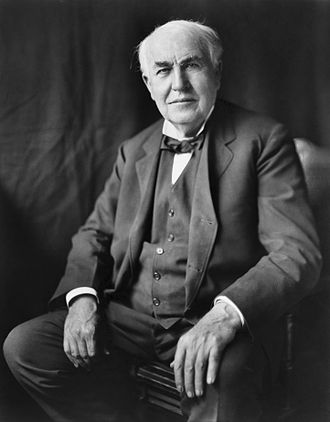

In [ ]:
r = requests.get('http:' + target_image[0], stream=True)
if r.status_code == 200:                     #200 status code = OK
   with open("/content/drive/MyDrive/figure.jpg", 'wb') as f: 
      r.raw.decode_content = True
      shutil.copyfileobj(r.raw, f)
img = cv2.imread('/content/drive/MyDrive/figure.jpg')
cv2_imshow(img)

# Summarization

## Model

Using Transfer Learning through Pegasus for Abstractive summarization

In [ ]:
!pip install torch==1.8.2+cu111 torchvision==0.9.2+cu111 torchaudio===0.8.2 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:15:00tcmalloc: large alloc 1147494400 bytes == 0x55ebe581c000 @  0x7f2c5f0ae615 0x55ebab6084cc 0x55ebab6e847a 0x55ebab60b2ed 0x55ebab6fce1d 0x55ebab67ee99 0x55ebab6799ee 0x55ebab60cbda 0x55ebab67ed00 0x55ebab6799ee 0x55ebab60cbda 0x55ebab67b737 0x55ebab6fdc66 0x55ebab67adaf 0x55ebab6fdc66 0x55ebab67adaf 0x55ebab6fdc66 0x55ebab67adaf 0x55ebab60d039 0x55ebab650409 0x55ebab60bc52 0x55ebab67ec25 0x55ebab6799ee 0x55ebab60cbda 0x55ebab67b737 0x55ebab6799ee 0x55ebab60cbda 0x55ebab67a915 0x55ebab60cafa 0x55ebab67ac0d 0x55ebab6799ee
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:11:20tcmalloc: large alloc 1434370048 bytes == 0x55ec29e72000 @  0x7f2c5f0ae615 0x55ebab6084cc 0x55ebab6e847a 0x55ebab60b2ed 0x55ebab6fce1d 0x55ebab67ee99 0x55ebab6799ee 0x55ebab60cbda 0x55ebab67ed00 0x55ebab6799ee 0x55ebab60cbda 0x55ebab67b737 0x55ebab6fdc66 0x55eba

In [ ]:
!pip install SentencePiece

In [ ]:
# Install transformers
!pip install transformers

In [ ]:
# Importing dependencies from transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import pipeline

In [ ]:
#Load tokenizer 
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

In [ ]:
# Define summarization pipeline 
summarizer = pipeline(
    "summarization", 
    model="google/pegasus-xsum", 
    tokenizer=tokenizer, 
    framework="pt"
)

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

## Summary generaration

In [ ]:
#setting our summarizer
res = summarizer(chunks, max_length=120, min_length=30, do_sample=False)

In [ ]:
#obtaining the resultant summary by joining the chunks
final_summary = ' '.join([summ['summary_text'] for summ in res])
final_summary = re.sub(r"\"", "", final_summary )

In [ ]:
final_summary

"On this day in 1931, the US Patent and Trademark Office granted the first patent in the name of Thomas Edison, for the invention of the phonograph. Thomas Edison grew up in Port Huron, Michigan, the son of a coal miner and a telegraph operator who worked on the train line between Port Huron and Detroit. Thomas Alva Edison was one of the most influential inventors of the 20th Century, and his inventions were used by millions of people around the world. Thomas Edison's laboratory at Menlo Park was one of the most highly regarded in the United States, with a reputation for thoroughness and attention to detail. In his laboratory at Menlo Park, Thomas Edison was known as The Wizard of Menlo Park and he was described by the Washington Post as the most ingenious inventor in this country. Thomas Edison's invention of the carbon microphone was based on the idea that sound waves can be reproduced using a series of tiny granules made of carbon. Thomas Edison's incandescent light bulb was the res

## Representation
Saving to word file

In [ ]:
!pip install python-docx

     |████████████████████████████████| 5.6 MB 5.4 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184507 sha256=6c5e17acb91b50d30782fce3accbfafabb57da675d1230f3c543aabd305c090f
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [ ]:
import docx
from docx.shared import Pt, Inches
  
# Create an instance of a word document
doc = docx.Document()
  
# Add a Title to the document 
doc.add_heading(soup.title.text, 0)

 #Add a picture to the document
doc.add_picture('/content/drive/MyDrive/figure.jpg', width=Inches(3))
para = doc.add_paragraph().add_run(final_summary)

# Now save the document to a location 
doc.save('/content/drive/MyDrive/summarisation/gfg.docx')

Summary created at the specified location

## Using spacy
### Extractive summarisation

In [ ]:
!pip install pytextrank

In [ ]:
import spacy
import pytextrank

In [ ]:
!python -m spacy download en_core_web_lg

In [ ]:
# Create spaCy pipeline and add textrank to it

nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("textrank")

In [ ]:
doc = nlp(ARTICLE)

In [ ]:
for sent in doc._.textrank.summary(limit_phrases=5, limit_sentences=10):
      print(sent)

Glenmont estate is maintained and operated by the National Park Service as the Edison National Historic Site, as is his nearby laboratory and workshops including the reconstructed "Black Maria"—the world's first movie studio.[160] The Thomas Alva Edison Memorial Tower and Museum is in the town of Edison, New Jersey.[161] In Beaumont, Texas, there is an Edison Museum, though Edison never visited there.[162]
The Port Huron Museum, in Port Huron, Michigan, restored the original depot that Thomas Edison worked out of as a young news butcher.
Edison also appeared to have been worried about the high voltage from misinstalled AC systems killing customers and hurting the sales of electric power systems in general.[71] Primary was the fact that Edison Electric based their design on low voltage DC and switching a standard after they had installed over 100 systems was, in Edison's mind, out of the question.
By the end of 1887, Edison Electric was losing market share to Westinghouse, who had built

In [ ]:
phrases_and_ranks = [ 
    (phrase.chunks[0], phrase.rank) for phrase in doc._.phrases
]
phrases_and_ranks[:10]

[(Edison, 0.09317106894127805),
 (Thomas Edison, 0.09228468848630839),
 (Edison Electric, 0.09048203468167348),
 (Alva Edison, 0.08875254759843934),
 (Edison Museum, 0.08867436799982098),
 (Charles Edison, 0.08860867254441326),
 (Kinétoscope Edison, 0.0884710154254383),
 (Mary Edison, 0.08843635915961297),
 (Edison Township, 0.08841257146635724),
 (Edison Manufacturing, 0.08824665415277777)]

I have observed the pegasus summary to be more meaningful to not taken the summary generated from TextRank 